In [1]:
import os
from unicodedata import normalize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Exploratory Data Analysis

The last notebook was responsible for downloading the [Kaggle's São Paulo House Price dataset](https://www.kaggle.com/datasets/ex0ticone/house-prices-of-sao-paulo-city), filter irrelevant data (rentals, outliers) and saving it to ".parquet", a more convenient file format.

In this notebook, we will perform an Exploratory Data Analysis (EDA) of our dataset. Our goal is to get a better understanding of the dataset and identify any patterns or correlations between the features and the target variable (the house price). We will use various visualization techniques and statistical methods to explore the data and gain insights.

## Dataset Loading

Lets load our already processed dataset and check it.

In [2]:
processed_dataset_root_dir = os.path.join(os.path.dirname(os.path.abspath("")), "data", "processed")

In [3]:
sp_house_price = pd.read_parquet(os.path.join(processed_dataset_root_dir, "sp_sales_data.parquet"))
sp_house_price

,bairro,tipo_imovel,area_util,banheiros,suites,quartos,vagas_garagem,anuncio_criado,preco_venda,taxa_condominio,iptu_ano
0,Jardim da Saude,Casa de dois andares,388.0,3.0,1.0,4.0,6.0,2017-02-07,700000,NaN,NaN
1,Vila Santa Teresa (Zona Sul),Casa,129.0,2.0,1.0,3.0,2.0,2016-03-21,336000,NaN,NaN
2,Vila Olimpia,Apartamento,80.0,2.0,1.0,3.0,2.0,2018-10-26,739643,686.0,1610.0
3,Pinheiros,Apartamento,94.0,1.0,0.0,3.0,2.0,2018-05-29,630700,1120.0,489.0
4,Vila Santa Clara,Condominio,110.0,1.0,1.0,3.0,2.0,2018-04-16,385000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
89437,Vila Carmosina,Apartamento,48.0,1.0,0.0,2.0,1.0,2017-10-07,171150,244.0,0.0
89438,Bela Vista,Apartamento,60.0,1.0,NaN,1.0,1.0,2017-12-13,251999,273.0,86.0
89439,Liberdade,Apartamento,53.0,2.0,1.0,2.0,1.0,2018-11-28,249782,210.0,0.0
89440,Vila Lageado,Apartamento,20.0,3.0,2.0,3.0,2.0,2019-02-06,623000,NaN,NaN


In [4]:

sp_house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89442 entries, 0 to 89441
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bairro           89442 non-null  object        
 1   tipo_imovel      89442 non-null  object        
 2   area_util        87770 non-null  float64       
 3   banheiros        89437 non-null  float64       
 4   suites           81521 non-null  float64       
 5   quartos          89439 non-null  float64       
 6   vagas_garagem    87797 non-null  float64       
 7   anuncio_criado   89442 non-null  datetime64[ns]
 8   preco_venda      89442 non-null  int64         
 9   taxa_condominio  78703 non-null  float64       
 10  iptu_ano         73994 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 7.5+ MB


Our dataset now has 89441 entries and 10 features, including the target feature `preco_venda`. For the feature type we have `bairro` and `tipo_movel` as *objects*, `anuncio_criado` as *datetime*, `preco_venda` as an *integer* and the remaining features as *floats*, but don't let these types misguide you.

First of all, as it's own name sugests, `preco_venda` is in *monetary units* (**Reais** in this case), so it would be wise to consider those values as *floats*, and the decimal places would account for **cents**.

`banheiros`, `suites`, `quartos` and `vagas_garagem` as *floats* doesn't sounds good too. e.g.: 0.75 bathroom doesn't make sense. It's more likely that these features were considered *floats* by Pandas by the occurences of *missing values* in them, as these are represented by `nan` (a float value).

Speaking of *missing values*, they occur in some features. Let's how the features are affected by this.

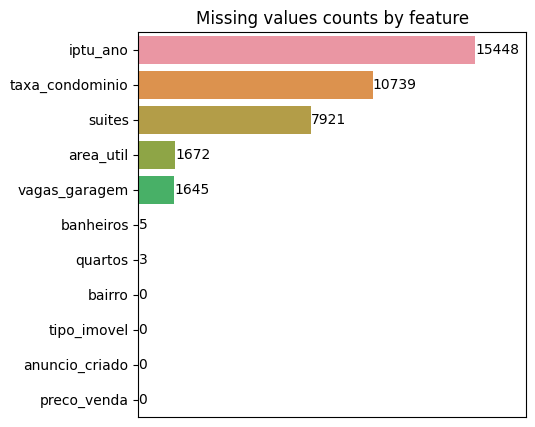

In [6]:
na_counts = sp_house_price.isna().sum(axis="rows").sort_values(ascending=False)

_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=na_counts, y=na_counts.index, ax=ax)

for p in ax.patches:
    x = p.get_x()
    y = p.get_y()
    width = p.get_width()
    height = p.get_height()
    ax.annotate(f"{int(width)}", (width + x, y + height * 0.65), ha="left")

ax.set_xlim([0, int(1.15 * na_counts.values[0])])
ax.axes.get_xaxis().set_visible(False)
ax.set_title("Missing values counts by feature");

`iptu_ano` is the feature with most *missing values*, followed by `taxa_condominio` and `suites`. Some of those missing values seems to be erros, as the lack of values would not make sense for `area_util`, `banheiros` and `quartos`. We'll deal with those values after our analysis, that will bring us some insights on how to handle them.